In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import collections
import math
import os
import random
import zipfile

In [3]:
from six.moves import urllib
from six.moves import xrange

In [4]:
import numpy as np
import tensorflow as tf

In [5]:
print(np.__version__)
print(tf.__version__)

1.15.4
1.10.0


In [6]:
DOWNLOAD_FILENAME = "SampleText.zip"
def download(url_path, expected_bytes):
    if not os.path.exists(DOWNLOAD_FILENAME):
        filename, _ = urllib.request.urlretrieve(url_path, DOWNLOAD_FILENAME)
        
        statinfo = os.stat(DOWNLOAD_FILENAME)
        if statinfo.st_size == expected_bytes:
            print("Found and verified file from this path : ", url_path)
            print("Downloaded filed: ", DOWNLOAD_FILENAME)
        else:
            print(statinfo.st_size)
            raise Exception("Failed to verify file from " + url_path + " Can you get with a browser?")                

In [7]:
def read_words():
    with zipfile.ZipFile(DOWNLOAD_FILENAME) as f:
        firstfile = f.namelist()[0]
        filestring = tf.compat.as_str(f.read(firstfile))
        words = filestring.split()
    
    return words

In [8]:
URL_PATH = 'http://mattmahoney.net/dc/text8.zip'
FILE_SIZE = 31344016
download(URL_PATH, FILE_SIZE)

In [9]:
voc = read_words()

In [10]:
len(voc)

17005207

In [11]:
voc[:25]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes']

In [12]:
def build_dataset(words, n_words):
    word_counts = [['UNKOWN', -1]]
    
    counter = collections.Counter(words)
    word_counts.extend(counter.most_common(n_words-1))
    
    dictonary = dict()
    
    for word, _ in word_counts:
        dictonary[word] = len(dictonary)
    
    word_indexes = list()
    unkown_count = 0
    for word in words:
        if word in dictonary:
            index = dictonary[word]
        else:
            index = 0
            unkown_count += 1
        
        word_indexes.append(index)
    
    word_counts[0][1] = unkown_count
    
    reversed_dictonary = dict(zip(dictonary.values(), dictonary.keys()))
    
    return word_counts, word_indexes, dictonary, reversed_dictonary    

In [13]:
VOC_SIZE = 10000
word_counts, word_indexes, dictonary , reversed_dictonary = build_dataset(voc, VOC_SIZE)

In [14]:
word_counts[:10]

[['UNKOWN', 1737307],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [15]:
word_indexes[:10]

[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]

In [16]:
import random
for key in random.sample(list(dictonary), 10):
    print(key, ":", dictonary[key])

beer : 2534
supposedly : 4834
brooklyn : 6010
biology : 2167
s : 15
pounds : 5379
surprise : 5151
UNKOWN : 0
diamonds : 4266
denominations : 4697


In [17]:
import random
for key in random.sample(list(reversed_dictonary),10):
    print(key, ":", reversed_dictonary[key])

2119 : huge
6331 : hammer
7645 : perceive
7998 : offset
2914 : ensure
4426 : sight
6480 : prey
3685 : warm
6522 : fever
9056 : faso


In [18]:
del voc

In [19]:
global_index = 0

In [20]:
def generate_batch(word_indexes, batch_size, num_skips, skip_window):
    global global_index
    
    assert batch_size % num_skips == 0
    assert num_skips <=  2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1
    
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
    
    
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            
            targets_to_avoid.append(target)
            
            batch[i * num_skips + j] = buffer[skip_window] # the input word
            labels[i * num_skips + j, 0] = buffer[target] # the context words
        
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
    
    global_index = (global_index + len(word_indexes) - span) % len(word_indexes)
    
    return batch, labels

In [21]:
batch, labels = generate_batch(word_indexes, 10, 2, 5)

In [22]:
batch

array([   2,    2, 3134, 3134,   46,   46,   59,   59,  156,  156],
      dtype=int32)

In [23]:
labels

array([[ 128],
       [3081],
       [   6],
       [ 742],
       [  59],
       [   6],
       [ 742],
       [ 156],
       [  59],
       [3134]], dtype=int32)

In [24]:
for i in range(10):
    print(reversed_dictonary[batch[i]], ":", reversed_dictonary[labels[i][0]])

of : early
of : originated
abuse : a
abuse : working
first : used
first : a
used : working
used : against
against : used
against : abuse


In [25]:
global_index = 0

In [26]:
valid_size = 16
valid_window = 100

valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [27]:
num_samples = 64

In [28]:
batch_size = 128
embedding_size = 50 # no of hidden layers neuorns
skip_window = 2
num_skips = 2

In [29]:
tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [30]:
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [31]:
embeddings = tf.Variable(

    tf.random_uniform([VOC_SIZE, embedding_size], -1.0, 1.0))

embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [32]:
embeddings

<tf.Variable 'Variable:0' shape=(10000, 50) dtype=float32_ref>

In [33]:
embed

<tf.Tensor 'embedding_lookup:0' shape=(128, 50) dtype=float32>

In [34]:
nce_weights = tf.Variable(tf.truncated_normal([VOC_SIZE, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))

nce_bias = tf.Variable(tf.zeros(VOC_SIZE))

In [35]:
loss = loss = tf.reduce_mean(
                    tf.nn.nce_loss(weights=nce_weights,
                                   biases=nce_bias,
                                   labels=train_labels,
                                   inputs=embed,
                                   num_sampled=num_samples,
                                   num_classes=VOC_SIZE
                                  ))


In [36]:
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

In [37]:
l2_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))

normalized_embeddings = embeddings / l2_norm

In [38]:
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)

In [39]:
valid_embeddings

<tf.Tensor 'embedding_lookup_1:0' shape=(16, 50) dtype=float32>

In [40]:
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [41]:
init = tf.global_variables_initializer()

In [42]:
num_steps = 200001

In [43]:
with tf.Session() as session:
    init.run()
    
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(word_indexes, batch_size, num_skips, skip_window)
        
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        ـ, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        
        average_loss += loss_val
        
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            
            print("Average loss at step", step, ": ", average_loss)
            average_loss = 0
        
        if step % 10000 == 0:
            sim = similarity.eval()
            
            for i in xrange(valid_size):
                valid_word = reversed_dictonary[valid_examples[i]]
                top_k = 8 # number of nearest neighbour 

                nearest = (-sim[i, :]).argsort()[1: top_k+1]
                log_str = 'Nearest to %s: ' % valid_word
                
                for k in xrange(top_k):
                    close_word = reversed_dictonary[nearest[k]]
                    log_str = '%s %s' % (log_str, close_word)
                print(log_str)
            print("\n")
    final_embeddings = normalized_embeddings.eval()

Average loss at step 0 :  231.54934692382812
Nearest to as:  normal language reprinted warriors binary leisure welfare hosting
Nearest to in:  orbiting grt apple abraham occupying secret orleans tigers
Nearest to known:  feeling retreat indiana liturgy tis balkan efficiency knife
Nearest to into:  buddy companion websites pioneered ma find norms geologic
Nearest to th:  difficult idealism lisp ambient brunei achievements prolific contribution
Nearest to system:  results immune random processing ring tend bearing comes
Nearest to to:  database symptoms commerce moreover renaissance municipality virtually food
Nearest to use:  mg audio discoveries observer kind prophetic accordance hesse
Nearest to two:  tea stop sentenced sentences greece specialist nationalist duty
Nearest to UNKOWN:  ecuador leo totally reign deployment spherical ic affected
Nearest to these:  eta naked smaller guarantee defend owns additions barnabas
Nearest to from:  commissioned designated kissinger listen claiming

Average loss at step 62000 :  5.332933119535446
Average loss at step 64000 :  5.278655239224434
Average loss at step 66000 :  5.0153509520292285
Average loss at step 68000 :  5.2806887608766555
Average loss at step 70000 :  5.157667265892028
Nearest to as:  health bases general with december normal language travel
Nearest to in:  of and for by worn on former from
Nearest to known:  theory campaign discovered among films led groups feeling
Nearest to into:  ma buddy find websites companion uses act master
Nearest to th:  difficult rate lincoln nine cross church collection brunei
Nearest to system:  results tend random jews ring immune comes austrian
Nearest to to:  and protect exposed in from national make UNKOWN
Nearest to use:  audio mg kind nazi australian nearly slow hand
Nearest to two:  tea one seven three zero six sentences eight
Nearest to UNKOWN:  and agave joined laureate actual austria gore reign
Nearest to these:  smaller go defend experience johnson gravity photos agricultu

Average loss at step 122000 :  4.845334318161011
Average loss at step 124000 :  4.840962638616562
Average loss at step 126000 :  4.804213227033615
Average loss at step 128000 :  4.814798687934876
Average loss at step 130000 :  4.788633569121361
Nearest to as:  health bases normal general battleships with language creative
Nearest to in:  of for by and novels from former worn
Nearest to known:  feeling campaign discovered theory ezra among losing so
Nearest to into:  ma websites buddy companion find master keys act
Nearest to th:  difficult nine rate six achievements seven lieutenant cross
Nearest to system:  results tend random immune ring jews austrian anatomy
Nearest to to:  protect exposed make dvd made michael discovered national
Nearest to use:  audio mg kind nazi discoveries accordance slow samoa
Nearest to two:  one three tea seven zero six eight sentences
Nearest to UNKOWN:  agave actual joined laureate cantor airlines hitler clothes
Nearest to these:  eta defend go smaller wit

Average loss at step 182000 :  4.761171834588051
Average loss at step 184000 :  4.774622886419296
Average loss at step 186000 :  4.714841307282448
Average loss at step 188000 :  4.80199539244175
Average loss at step 190000 :  4.778107678771019
Nearest to as:  normal bases health language battleships general known welfare
Nearest to in:  novels pictures for former of from by rahman
Nearest to known:  feeling ezra campaign well losing so discovered among
Nearest to into:  ma websites buddy companion master act keys palace
Nearest to th:  difficult nine rate six achievements seven kilometers lieutenant
Nearest to system:  results tend random immune ring anatomy negotiate table
Nearest to to:  protect made exposed make dvd garden michael armies
Nearest to use:  audio mg kind accordance nazi discoveries slow samoa
Nearest to two:  one three zero tea seven six eight four
Nearest to UNKOWN:  agave cantor actual laureate joined airlines clothes objections
Nearest to these:  eta defend go witne

In [44]:
def save_words_embddings(embeddings, word_count):
    np.save('embeddings.npy',embeddings)
    
    words = [x[0] for x in word_counts]
    np.save('words.npy', words)

In [45]:
save_words_embddings(final_embeddings, word_counts)

In [52]:
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embds, labels, filename='tsne.png'):
    
    assert low_dim_embds.shape[0] >= len(labels)
    
    plt.figure(figsize=(18, 18))
    
    for i,label in enumerate(labels):
        x, y = low_dim_embds[i, :]
        
        plt.scatter(x, y)
        
        plt.annotate(label,
                    xy=(x,y),
                    xytext=(5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
    
    plt.savefig(filename)
    plt.show(filename)

In [48]:
from sklearn.manifold import TSNE
NUM_PLOT_POINTS = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')

low_dim_embds = tsne.fit_transform(final_embeddings[:NUM_PLOT_POINTS, :])

labels = [reversed_dictonary[i] for i in xrange(NUM_PLOT_POINTS)]

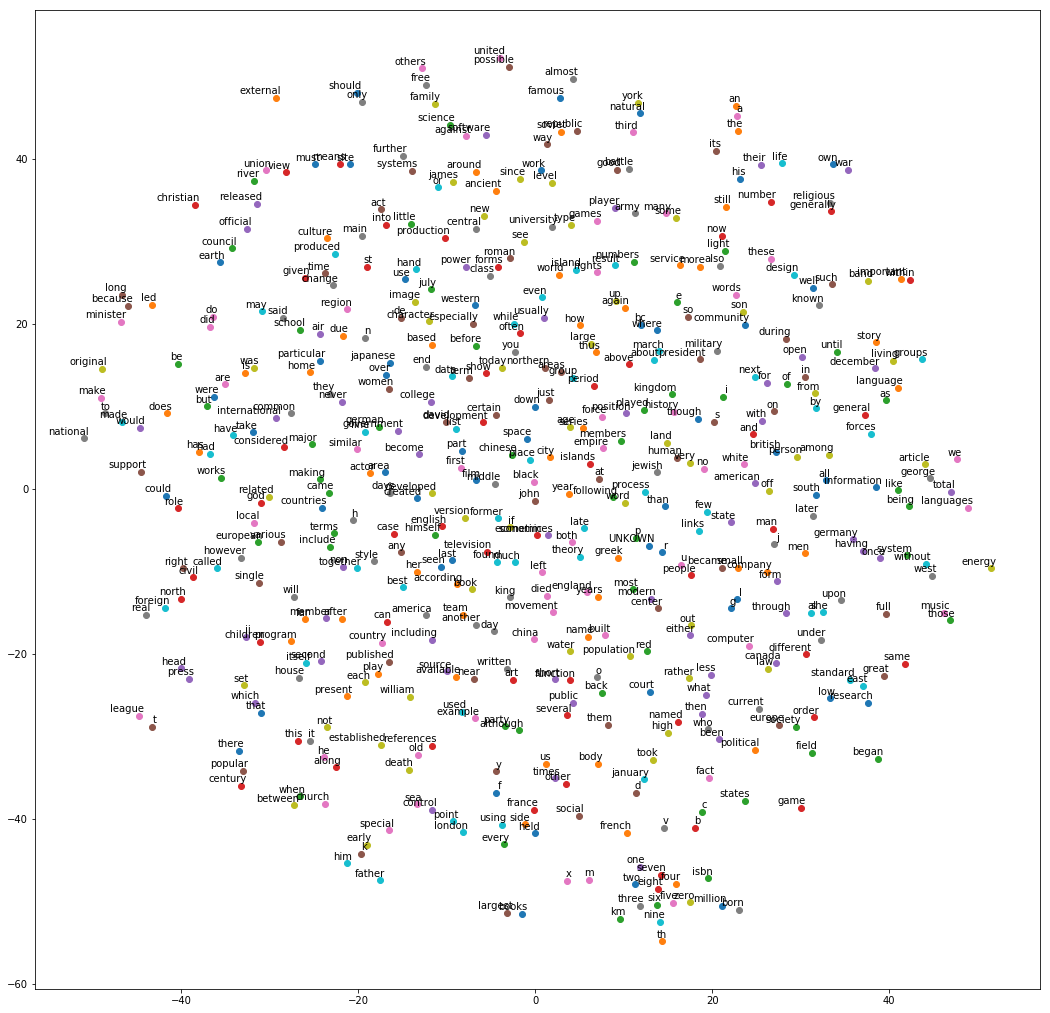

In [53]:
plot_with_labels(low_dim_embds, labels)